### Reading images

In [1]:
def read_image(prefix, source_path):
    #print(source_path)
    filename = source_path.split('/')[-1]
    #print(filename)
    filename = prefix + filename.split('\\')[-1]
    #print(filename)
    image = cv2.imread(filename)
    return image

In [2]:
import csv
import cv2
import numpy as np
from tqdm import tqdm

def read_dataset(prefix, images, measurements):

    lines = []
    with open( prefix + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    #for line in lines:
    for i in tqdm(range(0, len(lines), 1)):
        steering_center = float(lines[i][3])
        # create adjusted steering measurements for the side camera images
        correction = 0.2 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # Center
        images.append(read_image( prefix + 'IMG/', lines[i][0]))
        measurements.append(steering_center)
        # Left
        images.append(read_image( prefix + 'IMG/', lines[i][1]))
        measurements.append(steering_left)
        # Right
        images.append(read_image( prefix + 'IMG/', lines[i][2]))
        measurements.append(steering_right)

In [3]:
lines = []
images = []
measurements = []

# First dataset
read_dataset("./data/", images, measurements)

# # Smooth driving
# read_dataset("./smooth_driving/", images, measurements)

# #  Recovering
# read_dataset("./recovering_driving_1/", images, measurements)
# read_dataset("./recovering_driving_2/", images, measurements)
# read_dataset("./recovering_driving_3/", images, measurements)

#  Reverse driving
# read_dataset("./reverse_driving/", images, measurements)

100%|██████████| 8036/8036 [00:21<00:00, 374.15it/s]


### Image augmentation

In [4]:
def image_augmentation(images, measurements):   
    augmented_images, augmented_measurements = [], []
    # for image, measurement in zip(images, measurements, len(images)):
    for i in tqdm(range(0, len(images), 1)):
        image = images[i]
        measurement = measurements[i]
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image, flipCode=1))
        augmented_measurements.append(measurement*-1.0)
        
    return augmented_images, augmented_measurements

In [5]:
# from sklearn.utils import shuffle
# images, measurements = shuffle(images, measurements, random_state=0)

augmented_images, augmented_measurements = image_augmentation(images, measurements)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

100%|██████████| 24108/24108 [00:04<00:00, 5750.22it/s]


### Model

In [6]:
def getModel1():
    """
    Creates nVidea Autonomous Car Group model
    """
    from keras.models import Sequential
    from keras.layers import Flatten, Dense, Lambda, Dropout
    from keras.layers.convolutional import Conv2D
    from keras.layers.pooling import MaxPooling2D
    from keras.layers.convolutional import Cropping2D

    model = Sequential()
    # Normalize and mean centering the data 
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    model.add(Conv2D(24, (5, 5), strides=(2,2), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(48, (5, 5), strides=(2,2), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (5, 5), strides=(2,2), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(96, (3, 3), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

def getModel2():

    
    from keras.models import Sequential
    from keras.layers import Flatten, Dense, Lambda, Dropout
    from keras.layers.convolutional import Conv2D
    from keras.layers.pooling import MaxPooling2D
    from keras.layers.convolutional import Cropping2D

    model = Sequential()
    # Normalize and mean centering the data 
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    model.add(Conv2D(16, (3, 3), padding="same", input_shape=(32,32,3), activation = 'relu') )
    model.add(Conv2D(32, (3, 3), padding="same", activation = 'relu'))
    model.add(Conv2D(64, (3, 3), padding="same", activation = 'relu'))
    model.add(Conv2D(80, (3, 3), padding="same", activation = 'relu'))
    model.add(Conv2D(96, (3, 3), padding="same", activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [7]:
def drawTrainingLoss(history_object):
    from keras.models import Model
    import matplotlib.pyplot as plt

    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [8]:
# Get network
model = getModel1()
# Training
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=10, verbose = 2, batch_size=64)

Using TensorFlow backend.


Train on 38572 samples, validate on 9644 samples
Epoch 1/10
236s - loss: 0.0375 - val_loss: 0.0251
Epoch 2/10
237s - loss: 0.0246 - val_loss: 0.0268
Epoch 3/10
236s - loss: 0.0227 - val_loss: 0.0254
Epoch 4/10
237s - loss: 0.0211 - val_loss: 0.0211
Epoch 5/10
237s - loss: 0.0199 - val_loss: 0.0231
Epoch 6/10
238s - loss: 0.0193 - val_loss: 0.0228
Epoch 7/10
237s - loss: 0.0192 - val_loss: 0.0225
Epoch 8/10
237s - loss: 0.0191 - val_loss: 0.0221
Epoch 9/10
237s - loss: 0.0190 - val_loss: 0.0206
Epoch 10/10
240s - loss: 0.0190 - val_loss: 0.0215


dict_keys(['val_loss', 'loss'])


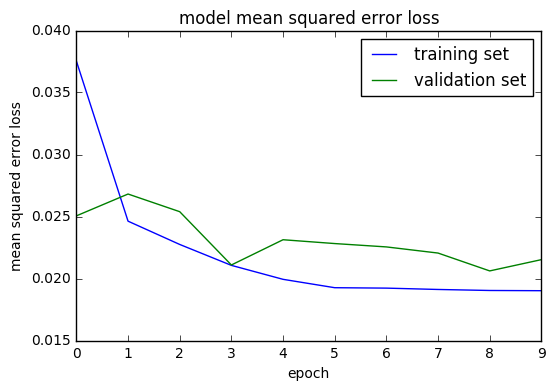

In [9]:
# Save modehistory_objectsave('model.h5')
drawTrainingLoss(history_object)

In [10]:
model.save('model.h5')